In [37]:
from IPython.display import Image, display
from pydantic import BaseModel, Field
from typing import List, Annotated, TypedDict
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.graph import START, END, MessagesState, StateGraph

In [17]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv
load_dotenv()

model = ChatGroq(model="llama-3.3-70b-versatile", temperature=0.5)

## **Defining the Schemas**

In [43]:
#This class will be for the technical questions and data retrieval from Arxiv Pinecone.
class Researcher(BaseModel):
    name: str = Field(description="The name of the researcher.")
    area_of_research: str = Field(description="The area of research of the researcher.")
    field_of_study: str = Field(description="The academic or professional field the researcher specializes in.")

    @property
    def persona(self) -> str:
        return f"Researcher Name: {self.name}\nArea of Research: {self.area_of_research}\nResearcher Affiliation: {self.affiliation}\n"


#This class will be responsible for the Web search looking for how the web has reacted to the research.
class Assistant(BaseModel):
    name: str = Field(description="The name of the assistant.")
    skills: List[str] = Field(description="A list of skills the assistant possesses.")
    tasks: List[str] = Field("The list of tasks assigned to the assistant by their supervisor.")

    @property
    def persona(self) -> str:
        return f"Assistant Name: {self.name}\Assistant Skills: {self.skills}\nTasks Assigned: {self.tasks}\n"


class QueryArxivState(BaseModel):
    query: str = Field(description="The search query to retrieve research papers from Arxiv.")
    extra_information: str = Field(description="Extra, non-technical, information that will be required to further improve research.")


class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [ ]:
class GeneratePersonas(TypedDict):
    researcher: Researcher
    assistant: Assistant


class OverallState(TypedDict):
    researcher: Researcher
    assistant: Assistant
    topic: str
    query: str
    extra_information: str
    search_query: str # To be replaced with the results of the web search!

# **Graph**

### Nodes

In [45]:
#Creating the Researcher and Analyst
generate_personas_prompt = """
You are tasked with generating two personas:

1. A persona for an expert researcher undergoing research in a specific topic.

2. A persona for an analyst which assists the expert researcher by gathering non-technical, external information related to the research topic.

The topic of the research currently undergoing is: {topic}
"""


def generate_personas(state: OverallState):
    
    sys_msg = generate_personas_prompt.format(topic = state["topic"])
    llm = model.with_structured_output(GeneratePersonas)

    response = llm.invoke([SystemMessage(content = sys_msg)] + [HumanMessage(content = "Generate the researcher and the analyst")])

    print(response)

    return {
        "researcher": response.researcher,
        "analyst": response.analyst
    }

researcher=Researcher(name='Dr. Rachel Kim', area_of_research='Deep Learning based Lane Detection Systems', affiliation='Stanford University') analyst=Analyst(name='John Lee', affiliation='MIT Consulting', area_of_expertise='Transportation Systems')


{'researcher': Researcher(name='Dr. Rachel Kim', area_of_research='Deep Learning based Lane Detection Systems', affiliation='Stanford University'),
 'analyst': Analyst(name='John Lee', affiliation='MIT Consulting', area_of_expertise='Transportation Systems')}

In [46]:
arxiv_query_prompt = """
You are an expert researcher given a topic for research. Your goal is to perform a literature review of the existing research related to the topic by generating a well-structured search query for retrieving relevant research papers from arxiv.

Here's your area of research and affiliation:
{persona}
"""

search_web_prompt = """
You are assistant to an expert researcher who gathers extra non-technical information about a research topic. The researcher will provide you with extra information based on which you have to create a web search query to search the web.

Here's your area of expertise:
{persona}


Pay careful attention to the information required by your researcher and generate a web search query accordingly.
"""

def generate_arxiv_query(state: OverallState):
    structured_llm = model.with_structured_output(QueryArxivState)

    query = structured_llm.invoke([SystemMessage(content = arxiv_query_prompt)] + [HumanMessage(content = state['topic'])])

    print(query)

    return {"query": query.query, "extra_information": query.extra_information}


def search_web(state: OverallState):
    system_message = search_web_prompt.format(topic = state['topic'])

    llm = model.with_structured_output(SearchQuery)
    query = llm.invoke([SystemMessage(content = system_message)] + [HumanMessage(content= f"The extra information required: {state['extra_information']}")])

    print(query)

    return {"search_query": query.search_query}
    

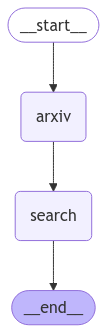

In [40]:
builder = StateGraph(OverallState)
builder.add_node("arxiv", generate_arxiv_query)
builder.add_node("search", search_web)

builder.add_edge(START, "arxiv")
builder.add_edge("arxiv", "search")
builder.add_edge('search', END)

graph = builder.compile()

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [41]:
graph.invoke({"topic": "Reasoning models"})

query='reasoning models' extra_information='current applications, future prospects, and potential challenges of reasoning models in various fields such as artificial intelligence, machine learning, and cognitive science.'
search_query='current applications and future prospects of reasoning models in artificial intelligence, machine learning, and cognitive science, potential challenges and limitations'


{'topic': 'Reasoning models',
 'query': 'reasoning models',
 'extra_information': 'current applications, future prospects, and potential challenges of reasoning models in various fields such as artificial intelligence, machine learning, and cognitive science.',
 'search_query': 'current applications and future prospects of reasoning models in artificial intelligence, machine learning, and cognitive science, potential challenges and limitations'}